# Importing Modules

In [1]:
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
import datetime
from matplotlib.gridspec import GridSpec

from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image

# Loading Data

In [2]:
df_sales_raw = pd.read_csv('train.csv',low_memory=False)
df_store_raw = pd.read_csv('store.csv',low_memory=False)

# Merge
df = pd.merge(df_sales_raw,df_store_raw,how='left',on='Store')

# Data Description

## Rename Columns

In [3]:
df.columns
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase,cols_old))
df.columns = cols_new


## Treating NA Values

In [4]:
df['date'] = pd.to_datetime(df['date'])
df.isna().sum()

## Filling NA

df['competition_distance'].max()
df['competition_distance'] = df['competition_distance'].fillna(200000)

df['competition_open_since_month'] = df.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

df['competition_open_since_year'] = df['competition_open_since_year'].fillna(df['date'].dt.year)
             
df['promo2_since_week'] = df['promo2_since_week'].fillna(df['date'].dt.isocalendar().week)

df['promo2_since_year'] = df['promo2_since_year'].fillna(df['date'].dt.year)
                 
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }
df['promo_interval'].fillna(0, inplace=True)
df['month_map'] = df['date'].dt.month.map(month_map)
df['is_promo'] = df[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

## Change Types

In [5]:
df.dtypes
df['competition_open_since_month'] = df['competition_open_since_month'].astype(int)
df['competition_open_since_year'] = df['competition_open_since_year'].astype(int)
df['promo2_since_week'] = df['promo2_since_week'].astype(int)
df['promo2_since_year'] = df['promo2_since_year'].astype(int)

## Descriptive Statistical

<AxesSubplot:xlabel='sales', ylabel='Count'>

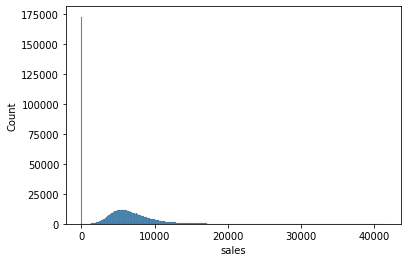

In [6]:
num_attributes = df.select_dtypes(include=['int64','float64'])
cat_attributes = df.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

d1 = num_attributes.describe().T
d2 = pd.DataFrame(num_attributes.apply(lambda x: x.skew()))
d2.columns = ['skew']
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis()))
d3.columns = ['kurtosis']
num_attributes_describe = pd.concat([d1,d2,d3],axis=1).reset_index()

sns.histplot(df['sales'])

In [7]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

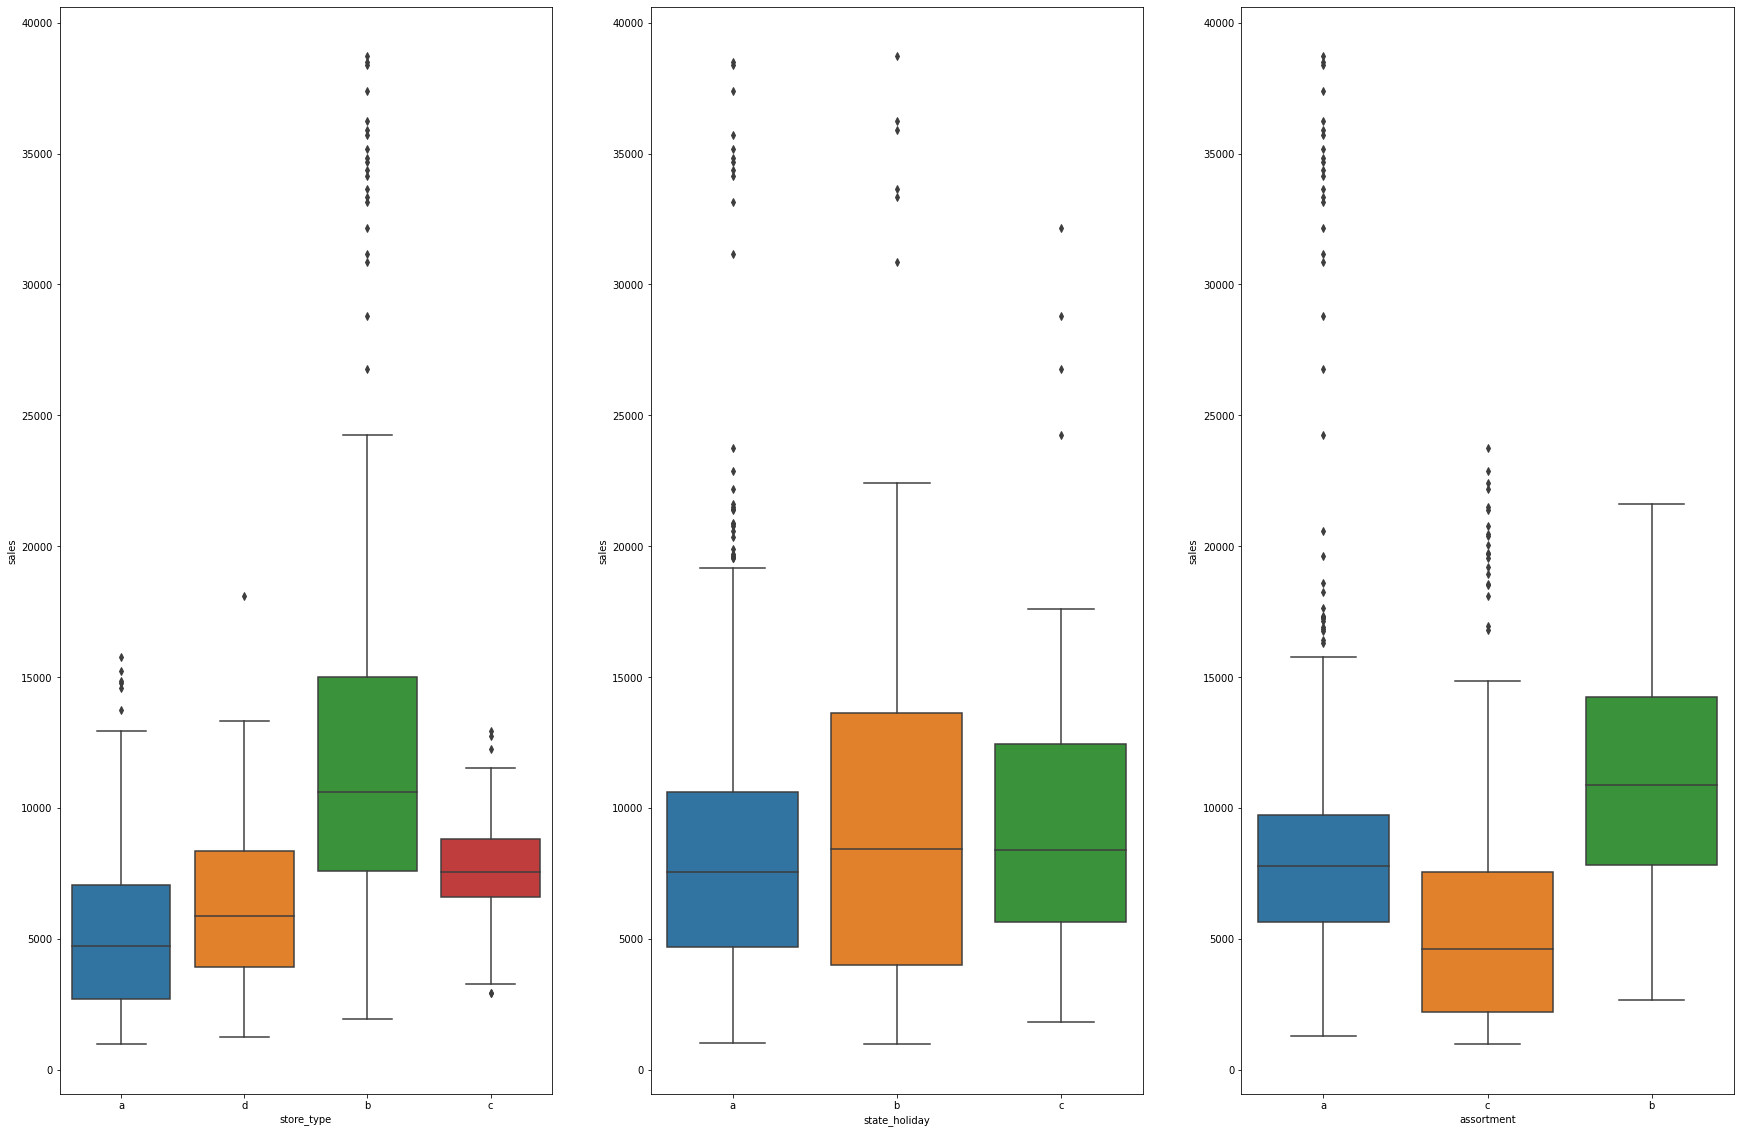

In [8]:
plt.rcParams['figure.figsize'] = [30, 20]
aux = df[(df['state_holiday'] != '0') & (df['sales'] > 0)]
plt.subplot(1,3,1)
sns.boxplot(x='store_type',y='sales',data=aux)            
plt.subplot(1,3,2)
sns.boxplot(x='state_holiday',y='sales',data=aux) 
plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux)

# Feature Engineering

## Hypothesis List

**1.** Lojas com maior sortimentos deveriam vender mais.
Store with assortment type "c" should have higher sales than type a and b.  
**2.** Lojas com competidores mais próximos deveriam vender menos.
Store close to the competitor should sell less    
**3.** Lojas com competidores à mais tempo deveriam vendem mais."
Store with 
**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
    
**5.** Lojas com mais dias de promoção deveriam vender mais.
    
**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

In [9]:
df2=df.copy()

## Feature Engineering

In [10]:
# year
df2['year']=df2['date'].dt.year
# month
df2['month']=df2['date'].dt.month
# day
df2['day']=df2['date'].dt.day
# week of year
df2['week_of_year']=df2['date'].dt.week
# year week
df2['year_week']=df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date']-df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1','%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date']-df2['promo_since'])/7).apply(lambda x:x.days).astype(int)

# assortment

df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extend')

# state holiday

df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x =='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')


<ipython-input-10-2d02db7cae96>:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year']=df2['date'].dt.week


In [11]:
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


# Variables Filtering

In [12]:
df3 = df2.copy()

In [13]:
df3 = df3[(df3['open']!=0) & (df3['sales']>0)]
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis=1)

# Exploratory Data Analysis

In [14]:
df4 = df3.copy()

## Response Variable

/Users/dwerneck/.pyenv/versions/dsproducao/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales'>

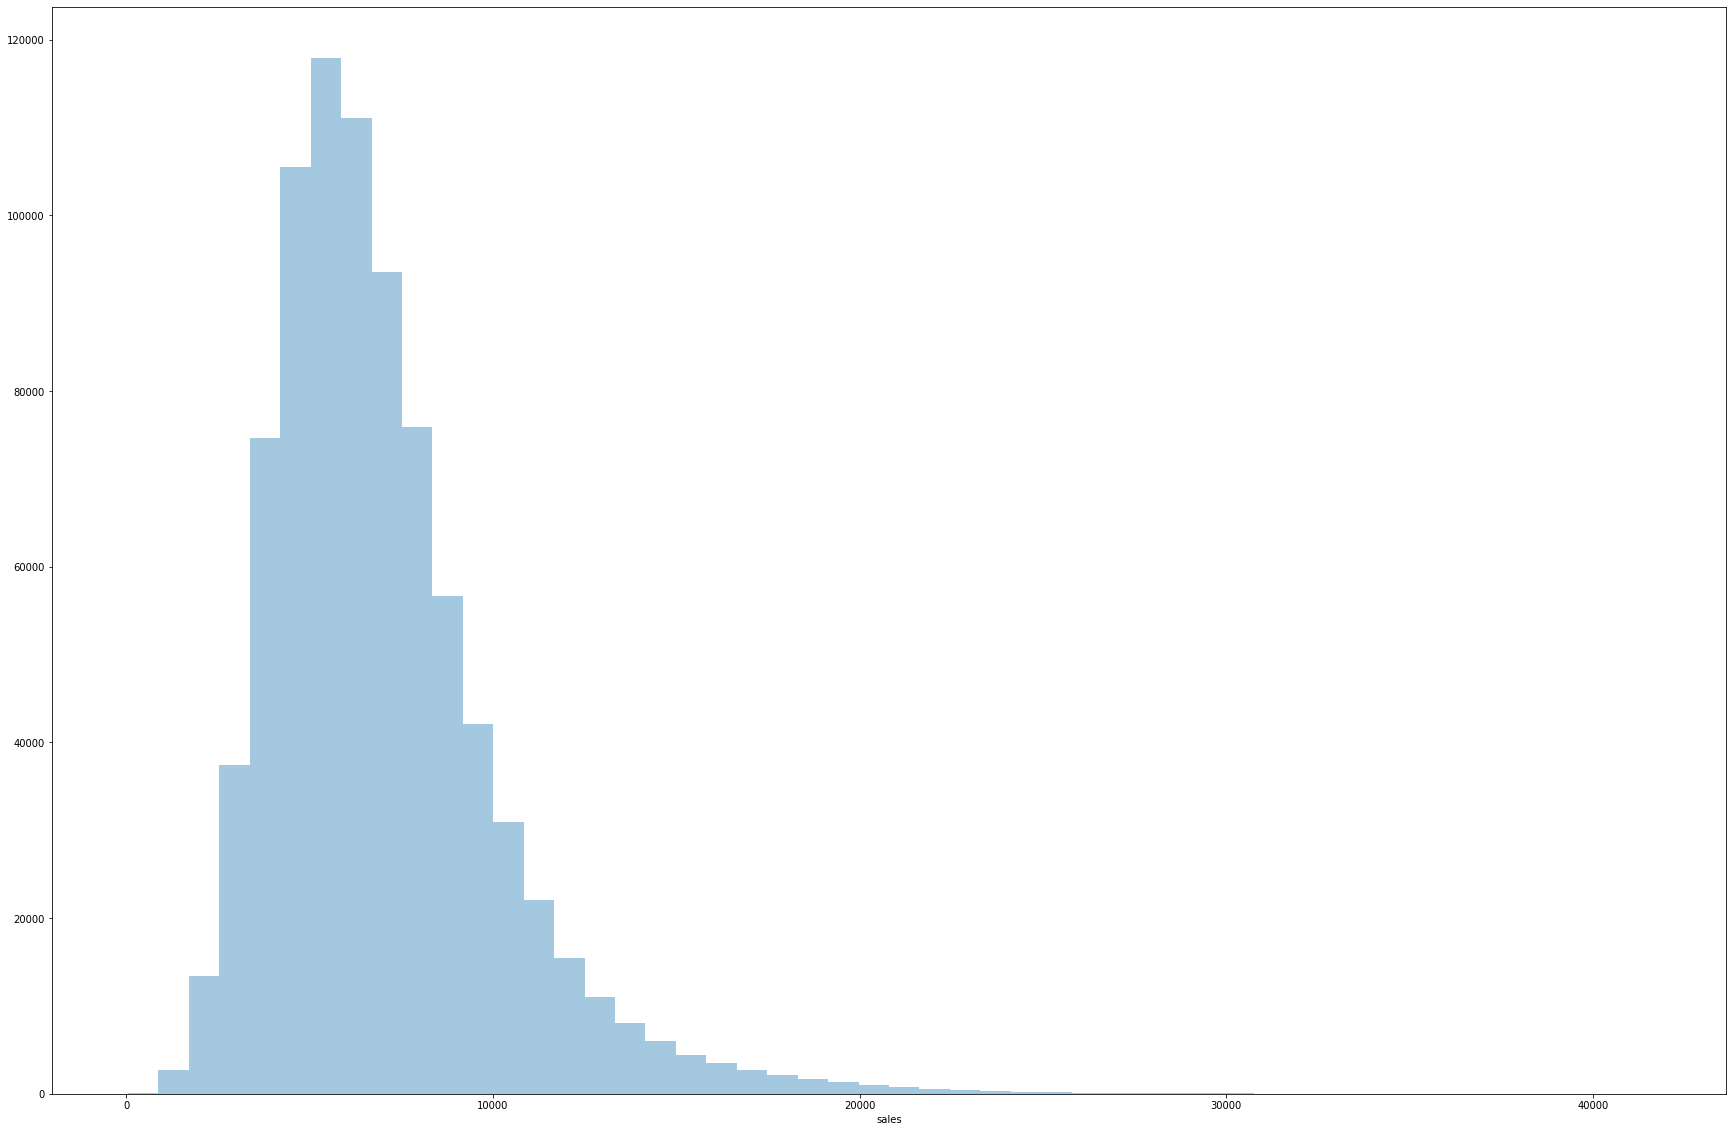

In [15]:
sns.distplot(df4['sales'],kde=False)

## Numerical Variable

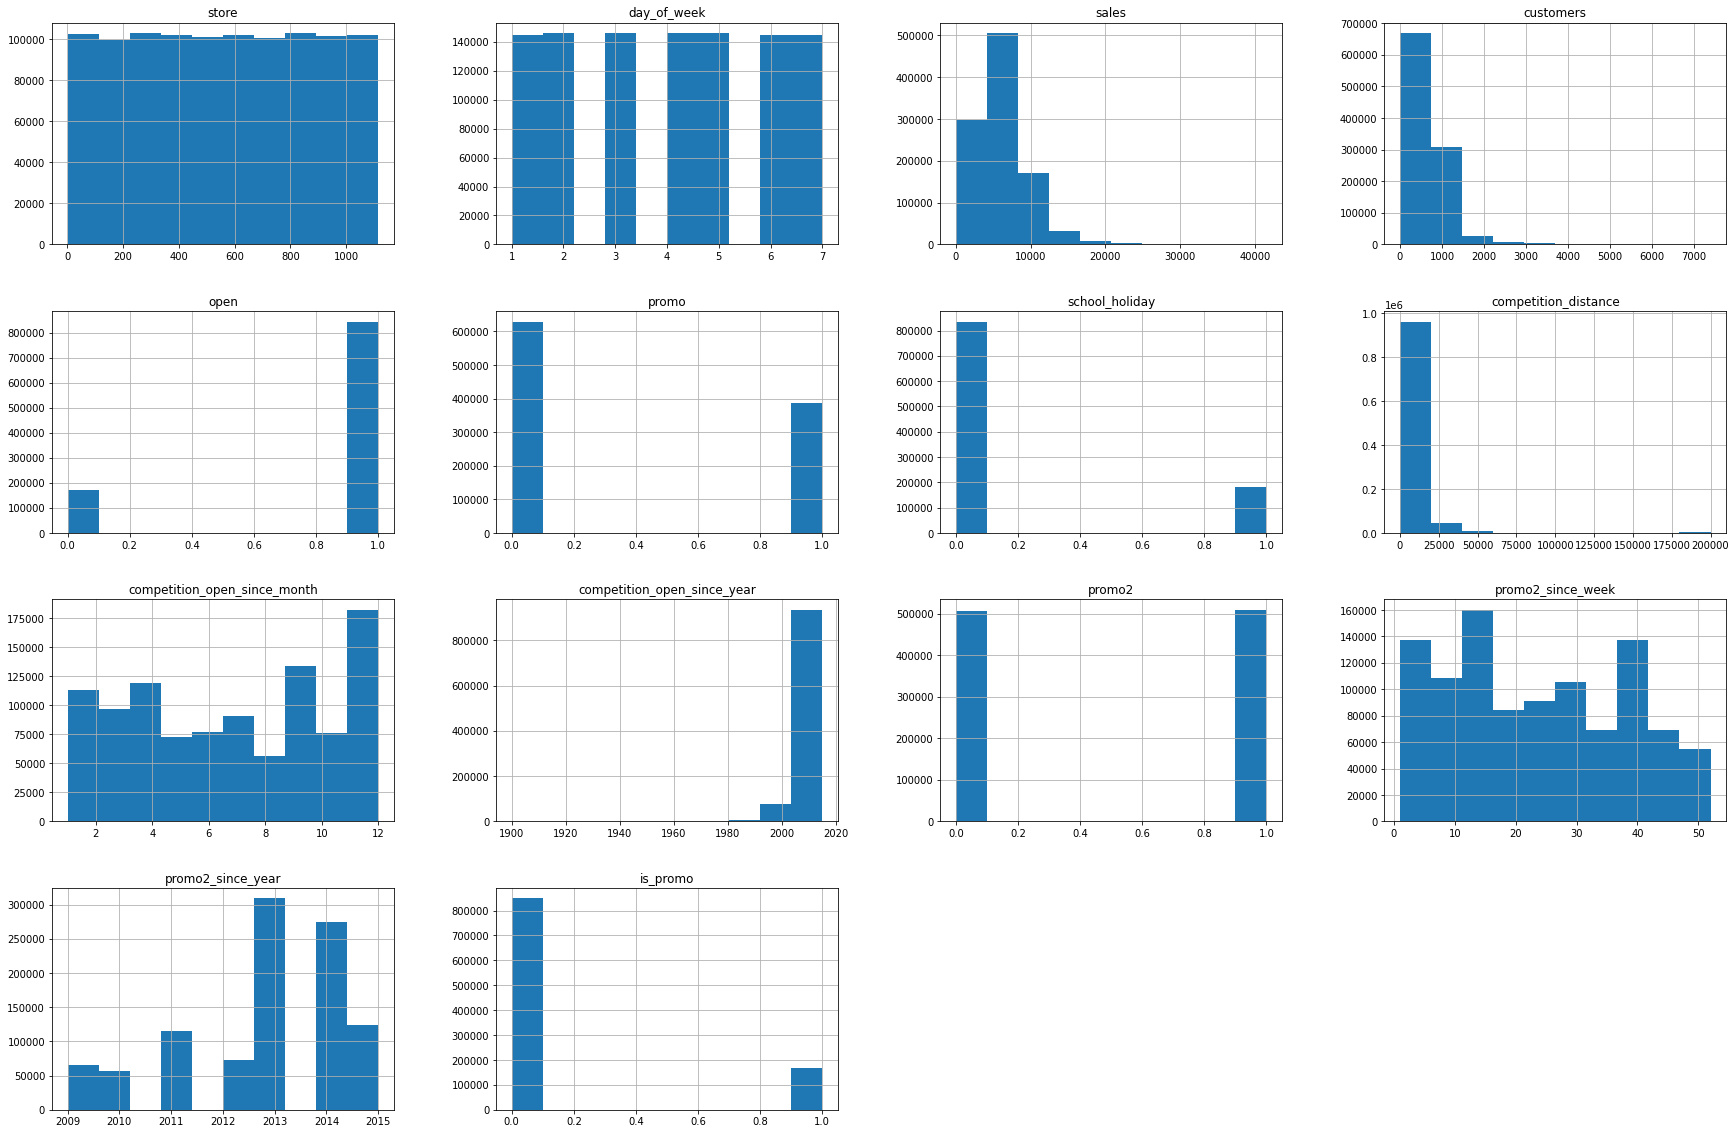

In [16]:
num_attributes.hist();

## Categorical Variable

In [17]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

/Users/dwerneck/.pyenv/versions/dsproducao/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/dwerneck/.pyenv/versions/dsproducao/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/dwerneck/.pyenv/versions/dsproducao/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will resul

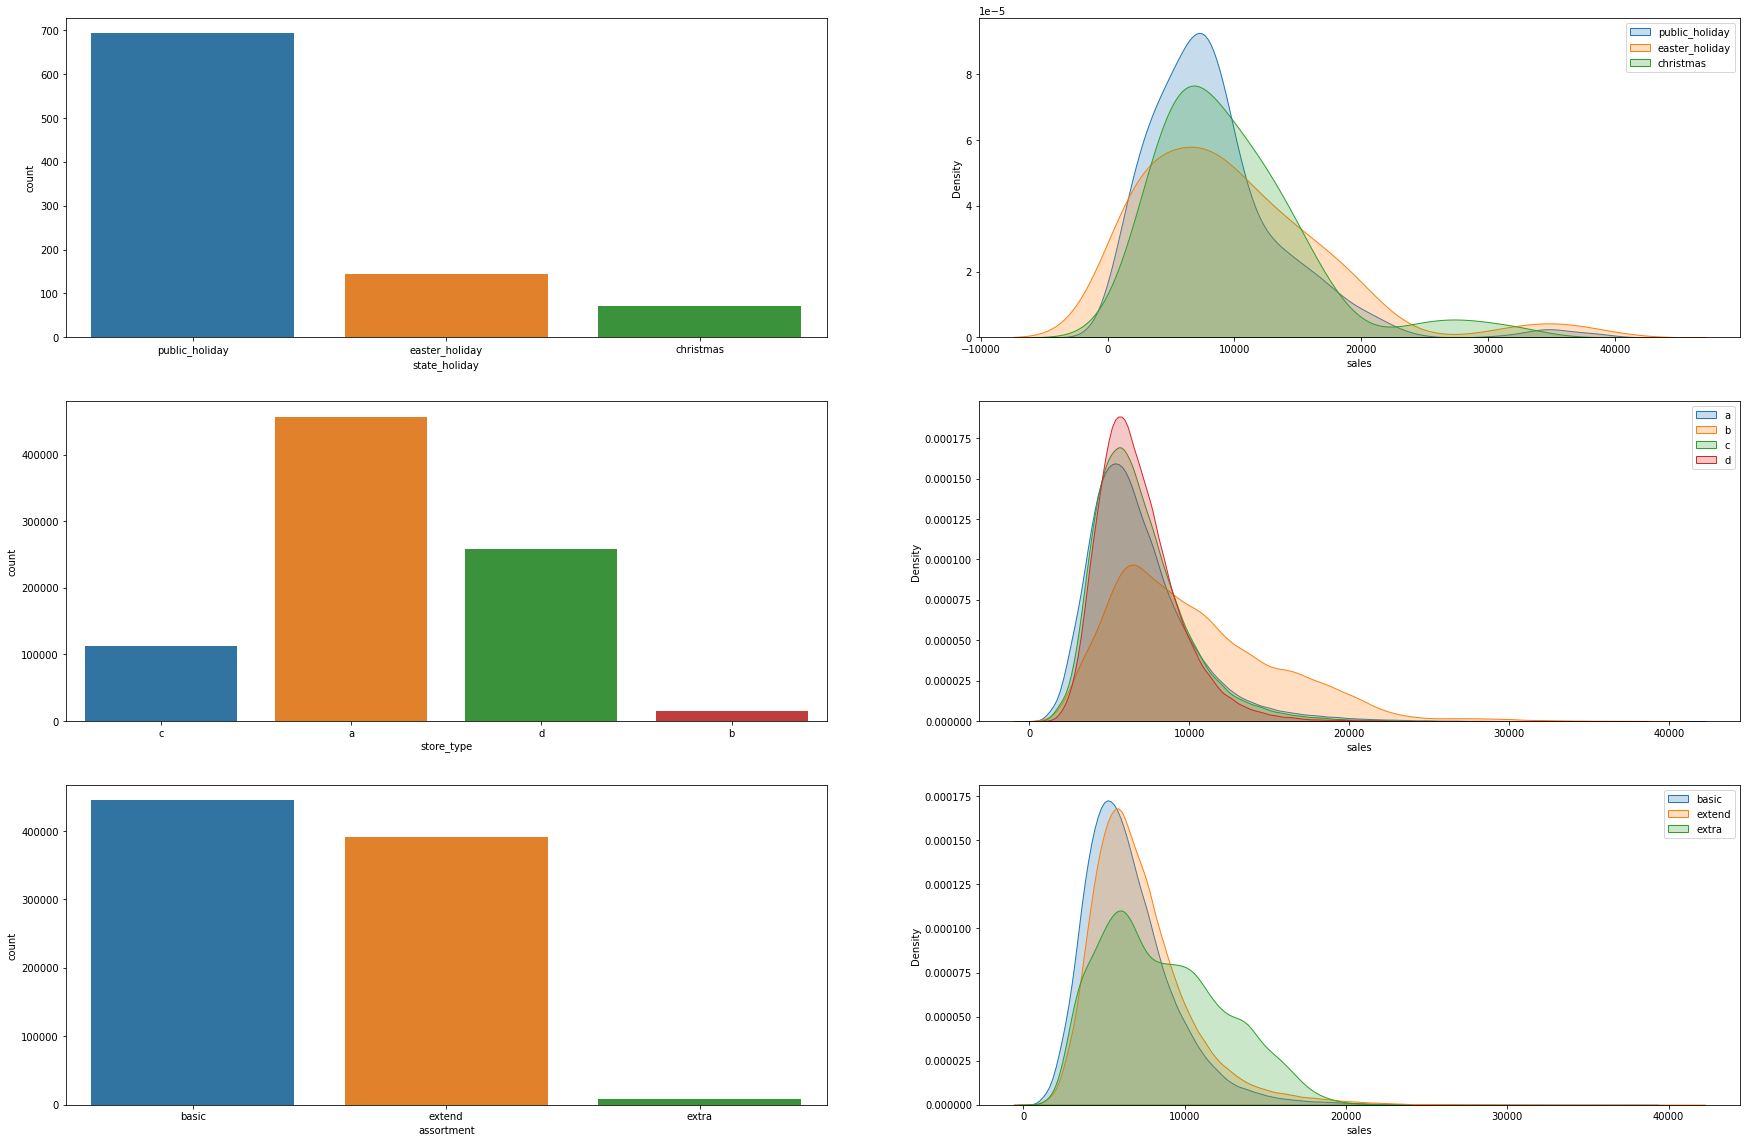

In [18]:
# State Holiday
a = df4[df4['state_holiday'] != 'regular_day']
plt.subplot(3,2,1)
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas',shade=True)
plt.legend()

# Store Type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a',shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b',shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c',shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d',shade=True)
plt.legend()

# Assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic',shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extend']['sales'], label='extend',shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra',shade=True)
plt.legend()



## Bivariate Analysis

### H1 - Store with more assortment should have higher sales.
***FALSE***

<AxesSubplot:xlabel='year_week'>

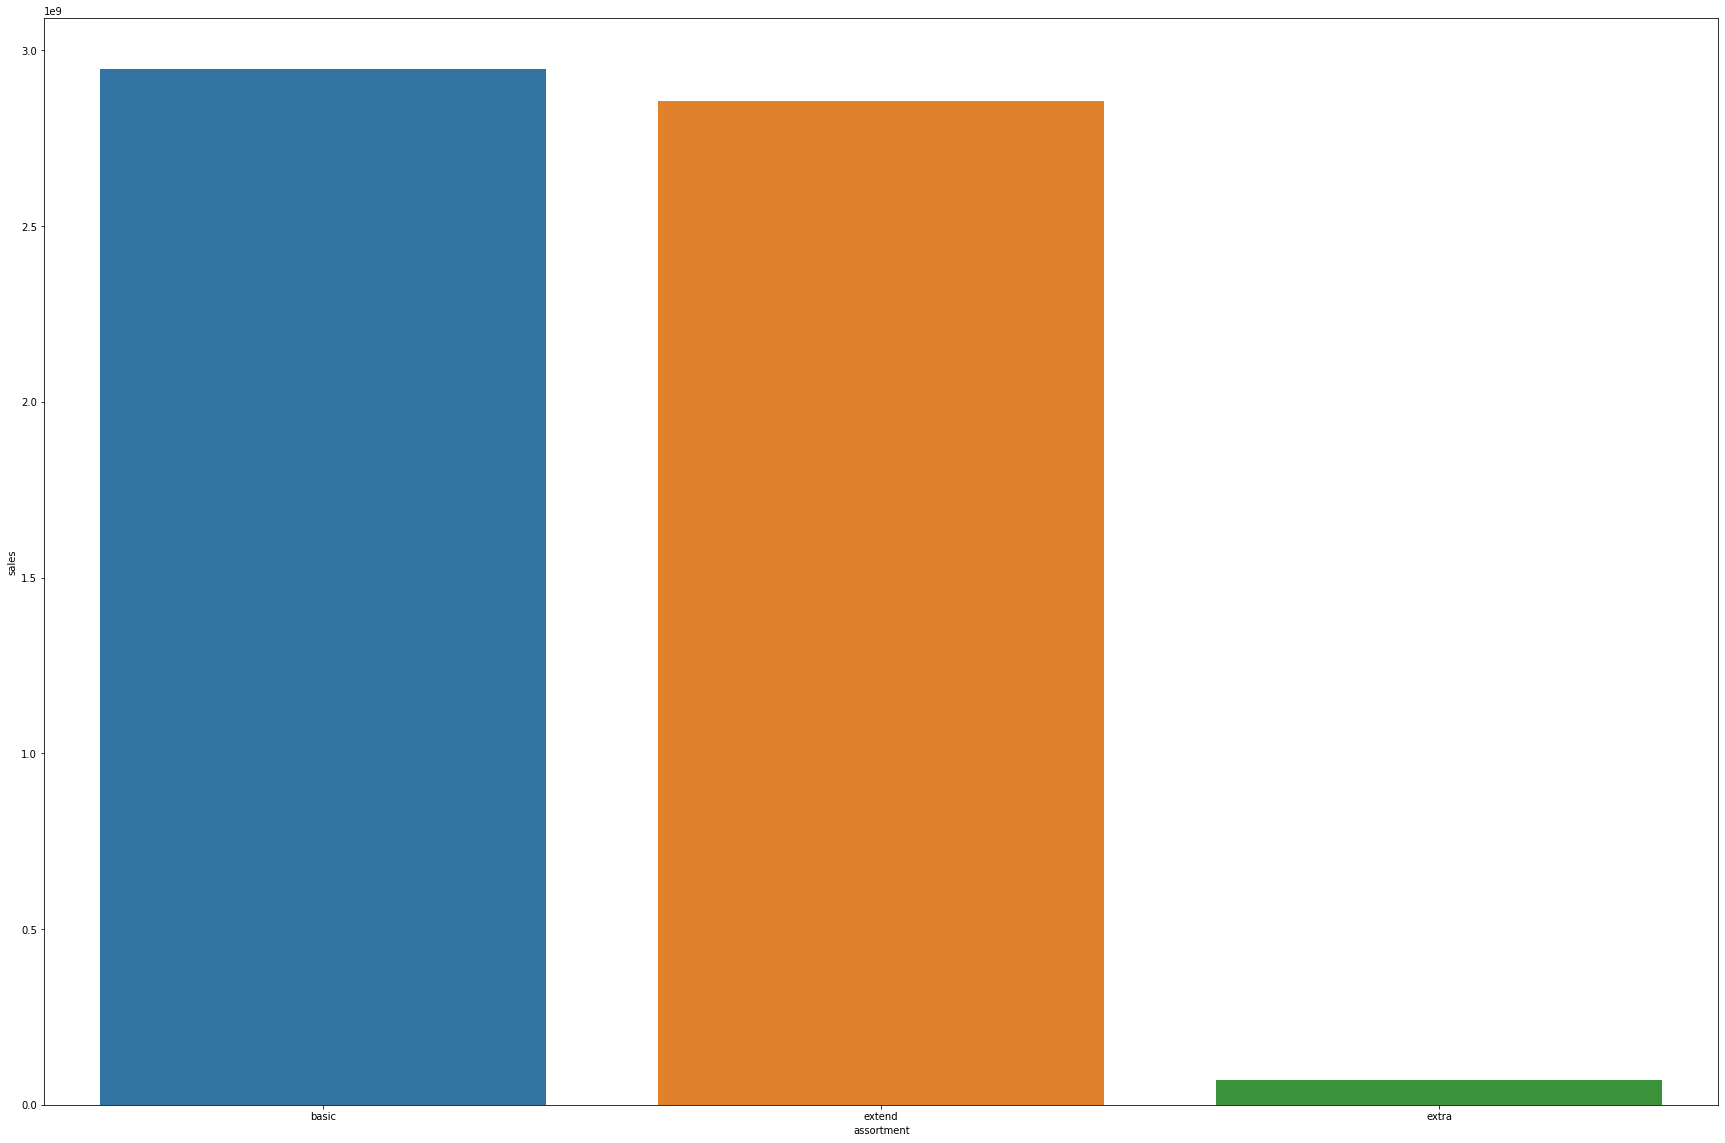

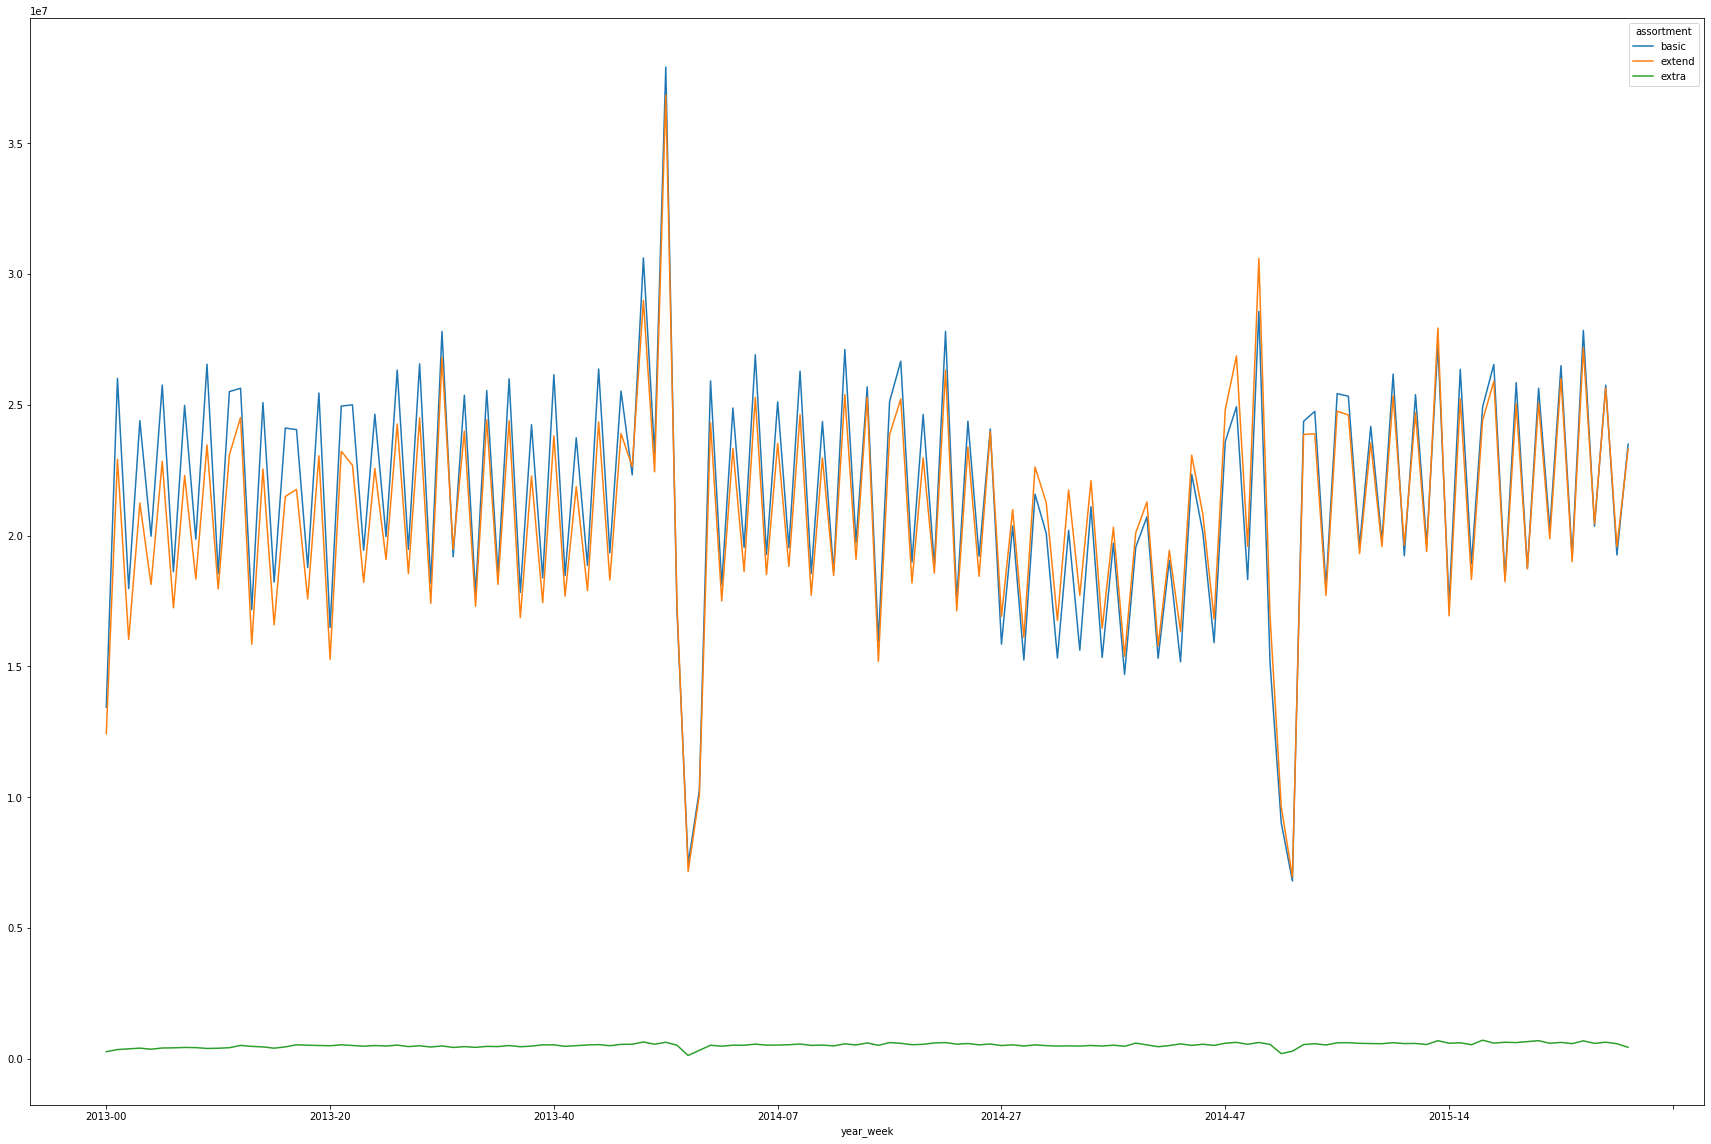

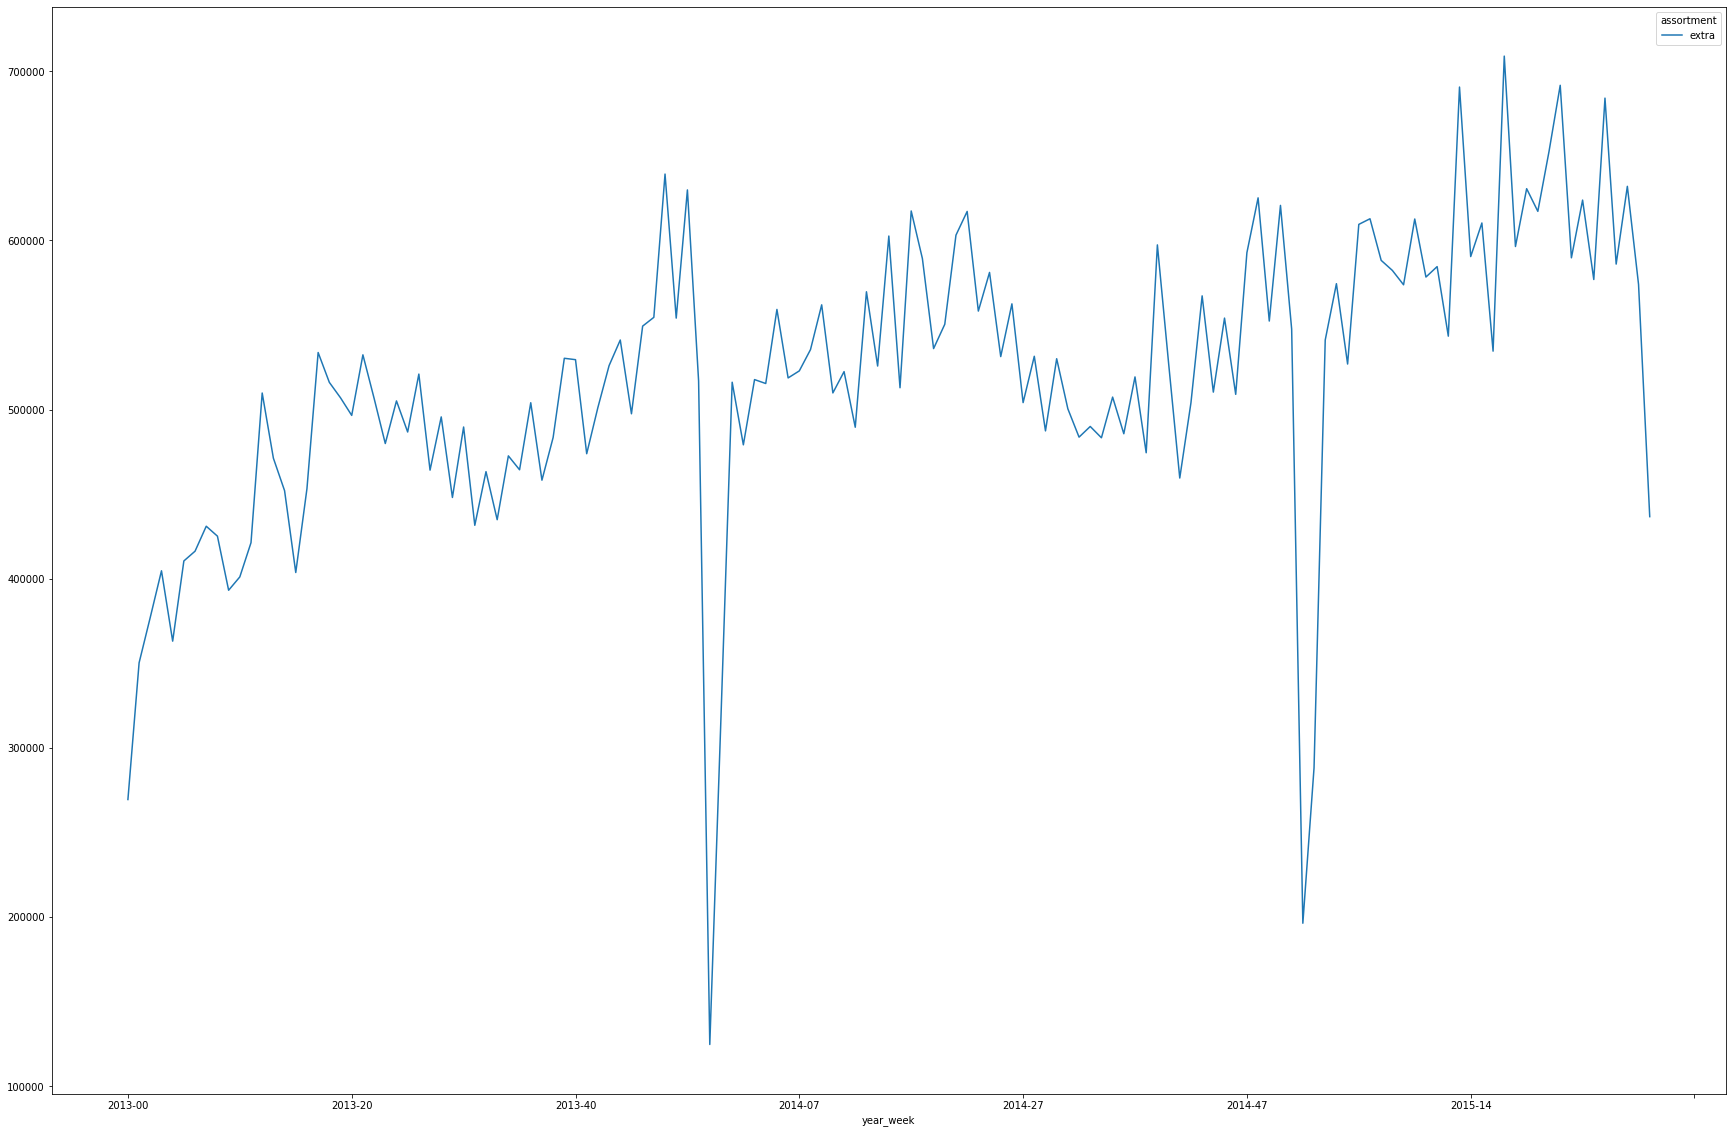

In [19]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment',y='sales',data=aux1);

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week',columns='assortment',values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week',columns='assortment',values='sales').plot()

### H2 - Store closer to the competitor should have lower sales 
***FALSE***

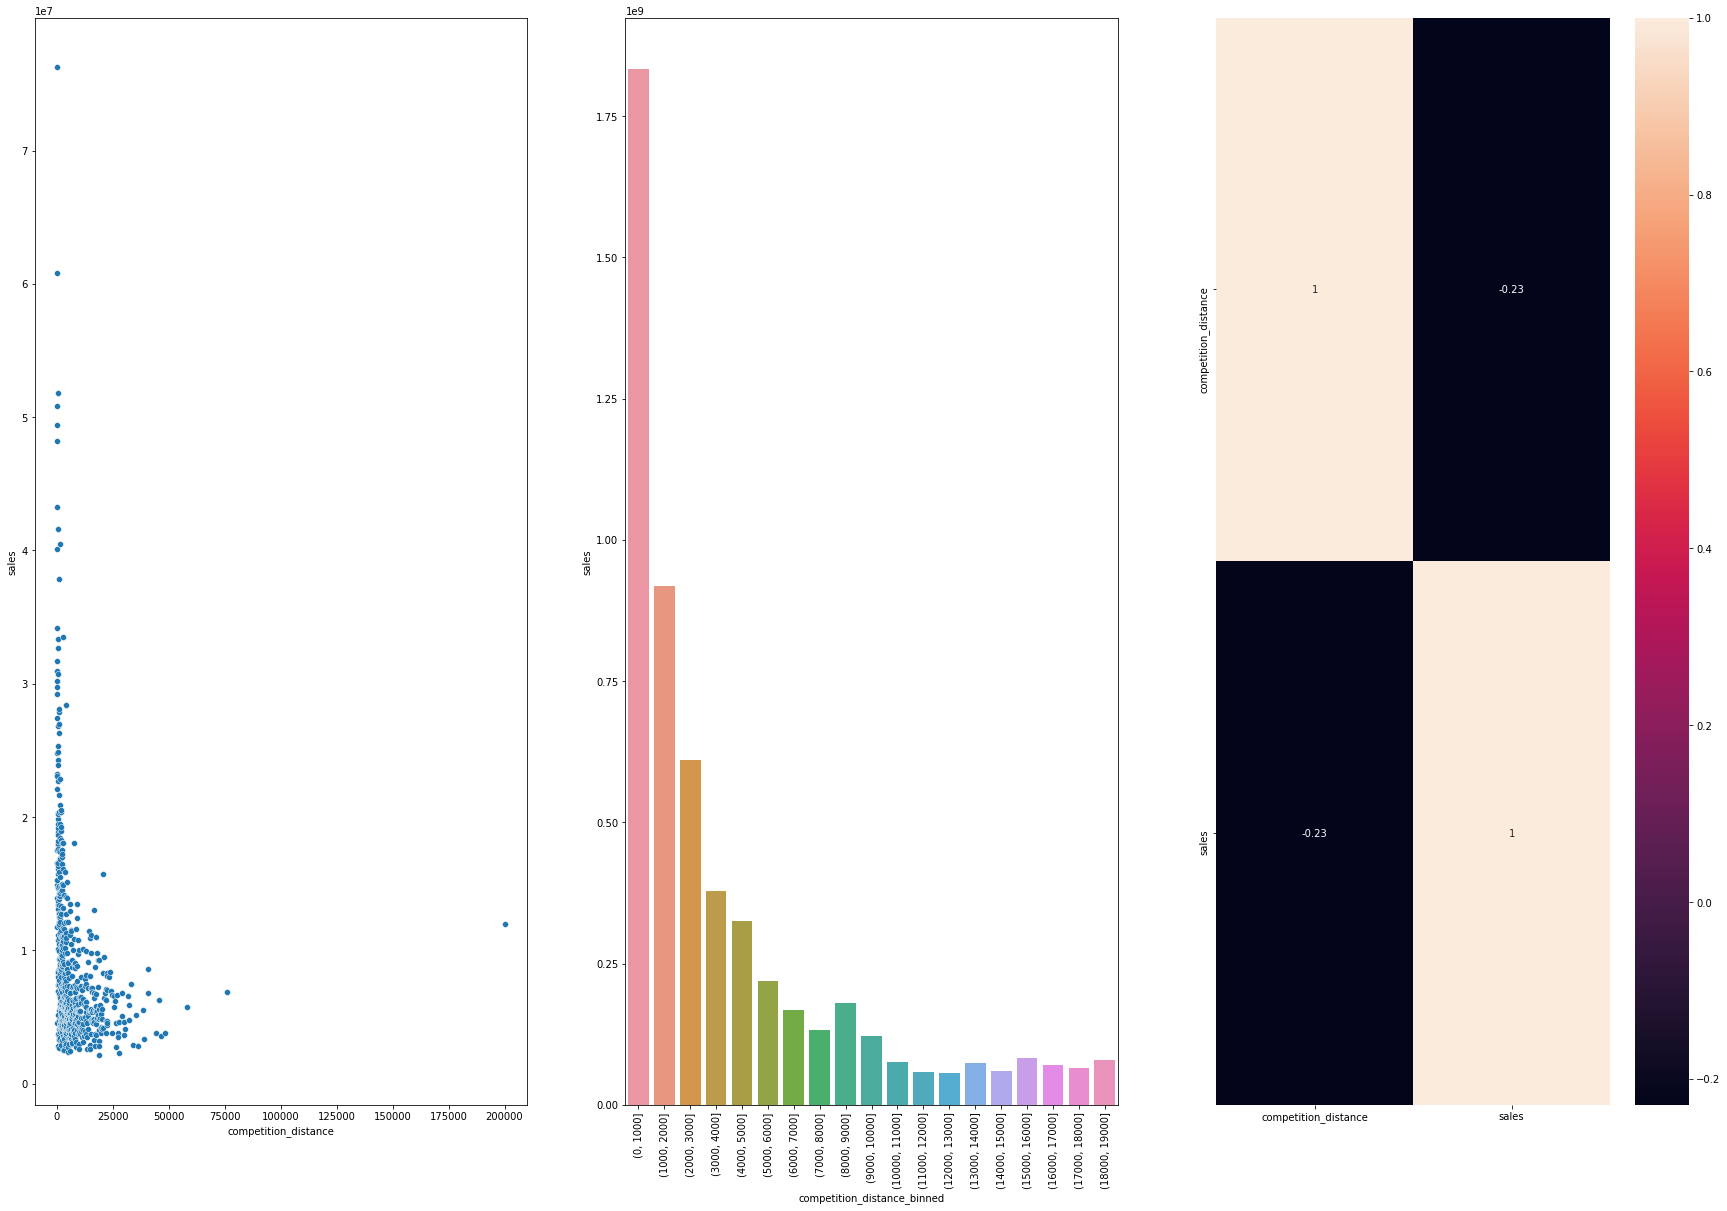

In [20]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance',y='sales',data=aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'],bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned',y='sales',data=aux2);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### H3 - Store with competitors for longer should have higher sales
***FALSE***

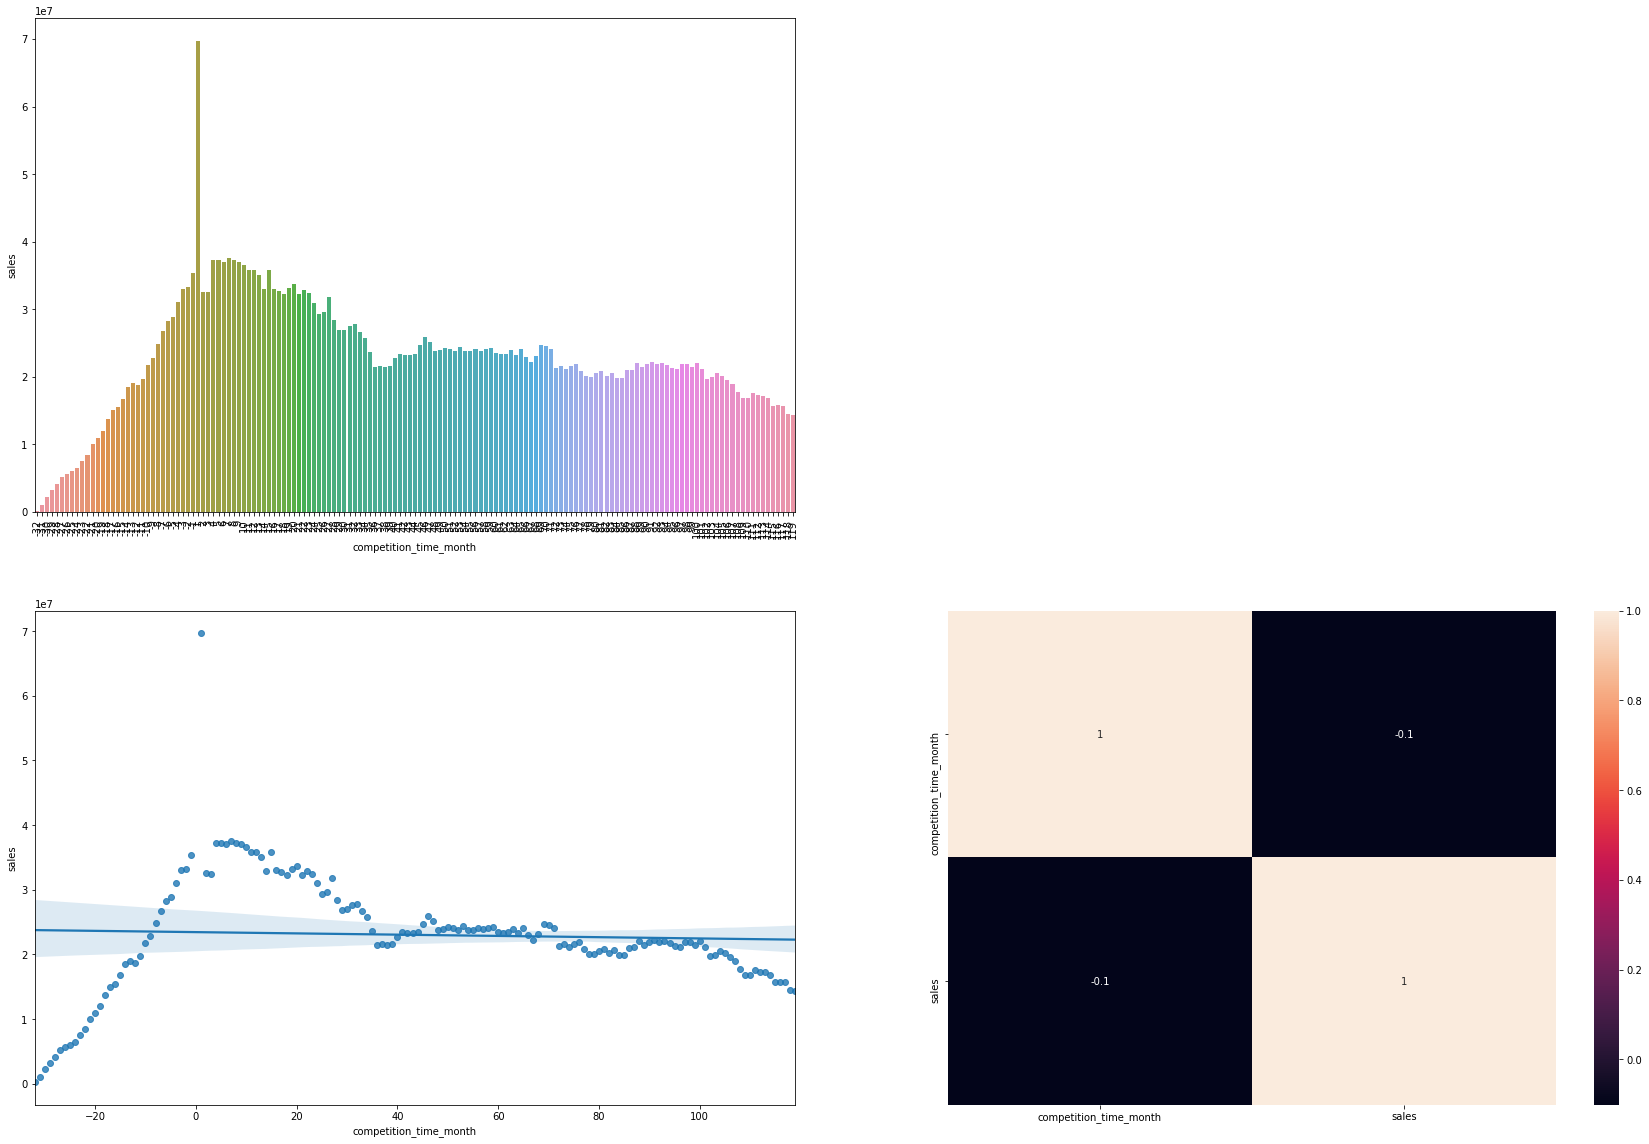

In [21]:
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120)  & (aux1['competition_time_month'] != 0)]

plt.subplot(2,2,1)
sns.barplot(x='competition_time_month',y='sales',data=aux2);
plt.xticks(rotation=90);

plt.subplot(2,2,3)
sns.regplot(x='competition_time_month',y='sales',data=aux2);

plt.subplot(2,2,4)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### H4 - Stores with longer activated promotions should have higher sales. 
***FALSE***

<AxesSubplot:>

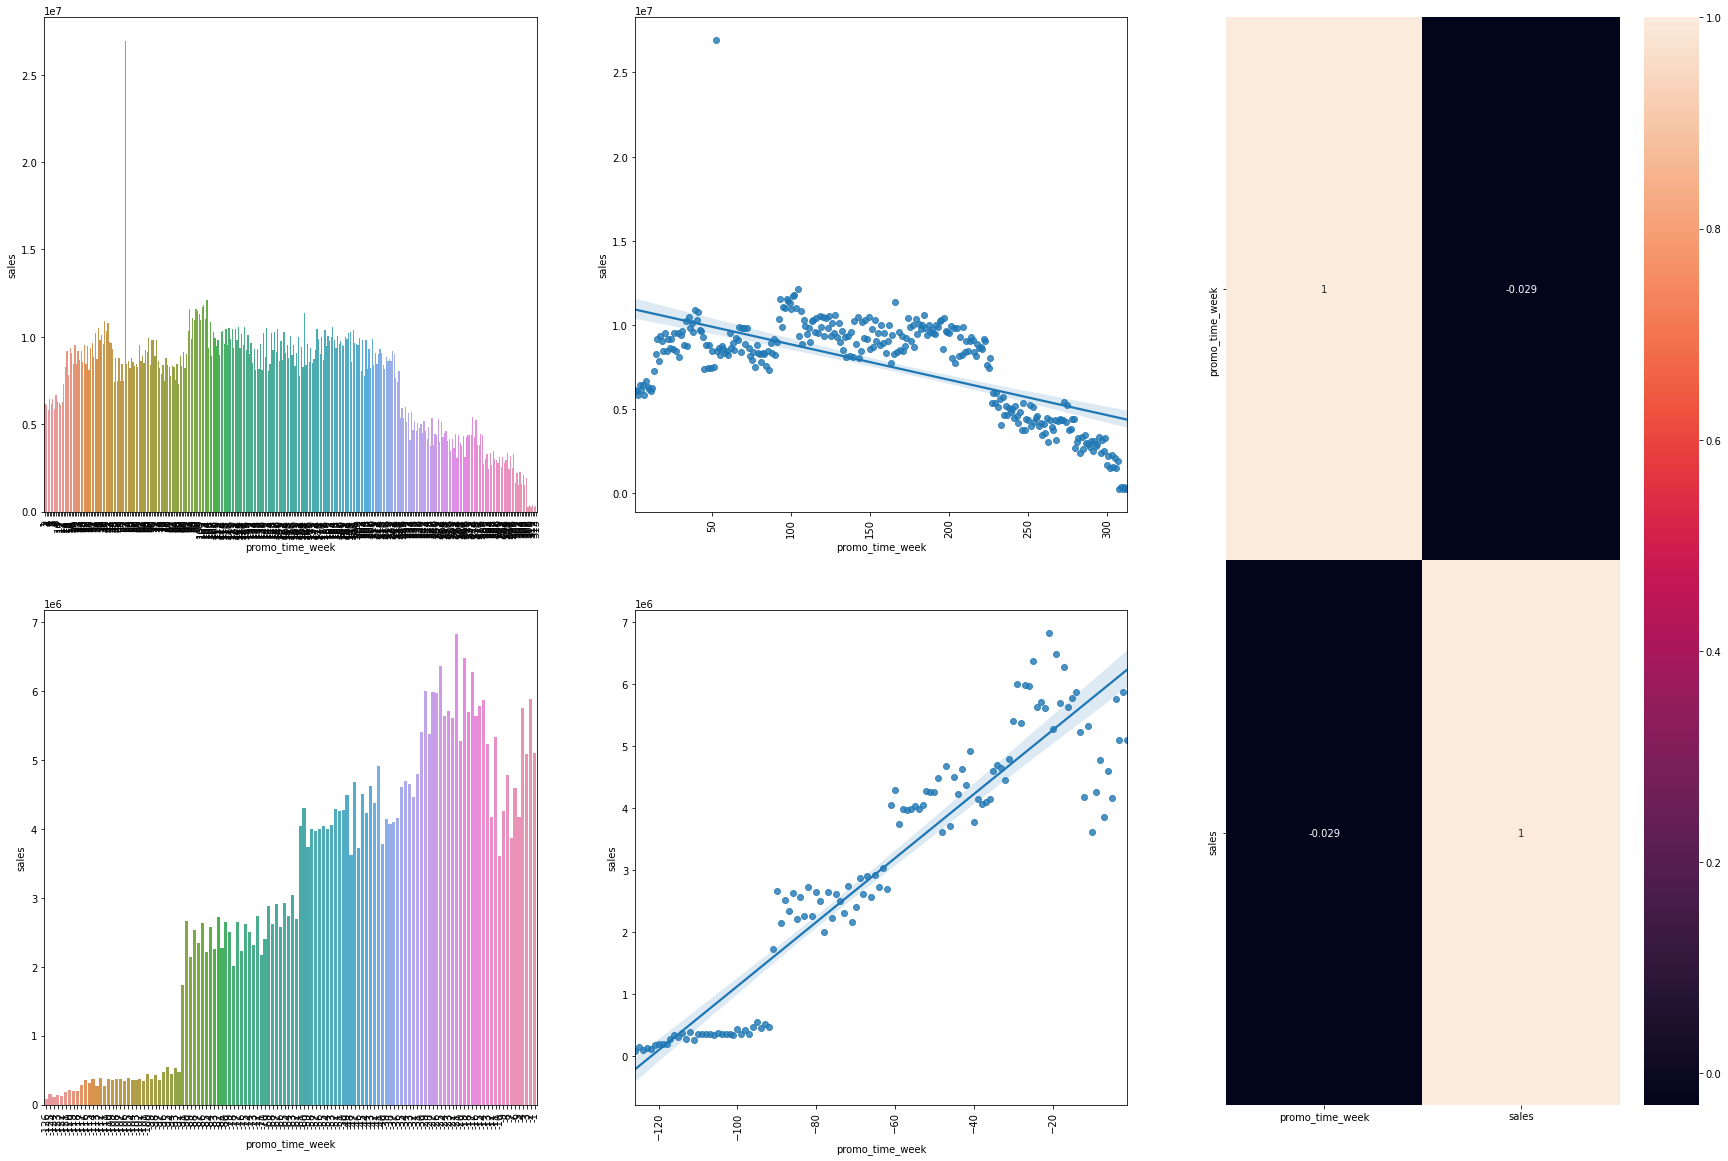

In [22]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()
#sns.barplot(x='promo_time_week',y='sales',data=aux1);

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week']>0] # promo extend period
sns.barplot(x='promo_time_week',y='sales',data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week',y='sales',data=aux2);
plt.xticks(rotation=90);


plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week']<0] # promo regular period
sns.barplot(x='promo_time_week',y='sales',data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week',y='sales',data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'),annot=True)

In [23]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extend,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


### <s> H5 - Stores with more days in promotion should have higher sales. </s>

### H6 - Stores with more consecutives promotions should have higher sales.
**FALSE**

In [24]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


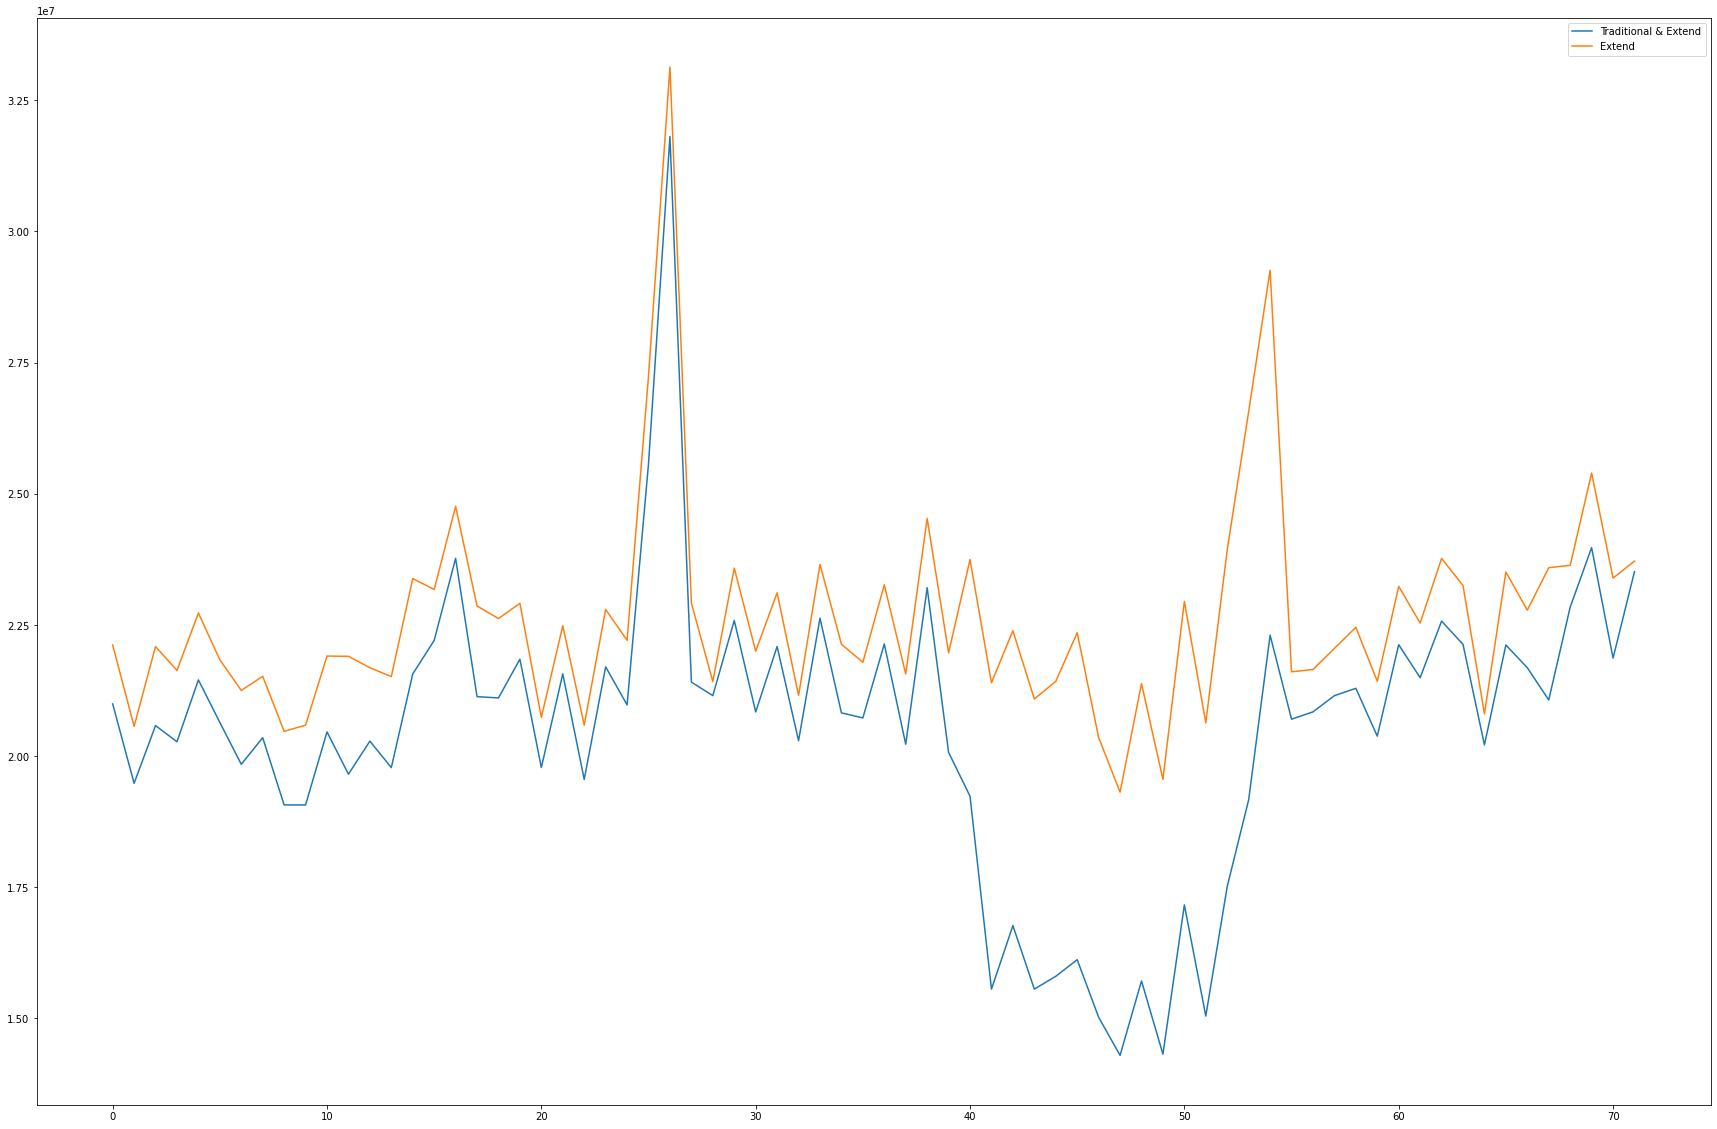

In [27]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Traditional & Extend','Extend'])

## Multivariate Analysis

In [28]:
df4

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extend,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,0,public_holiday,1,b,basic,150.0,...,0,2013,1,1,1,2013-00,2006-09-01,77,2012-12-31,0
1016827,733,2,2013-01-01,10765,0,public_holiday,1,b,extra,860.0,...,0,2013,1,1,1,2013-00,1999-10-01,161,2012-12-31,0
1016863,769,2,2013-01-01,5035,0,public_holiday,1,b,extra,840.0,...,1,2013,1,1,1,2013-00,2013-01-01,0,2012-11-19,6
1017042,948,2,2013-01-01,4491,0,public_holiday,1,b,extra,1430.0,...,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0
